In [1]:
import numpy
import matplotlib.pyplot

In [2]:
data_file = open("mnist_train_100.csv", 'r')
data_list = data_file.readlines()
data_file.close()

In [3]:
len(data_list)

100

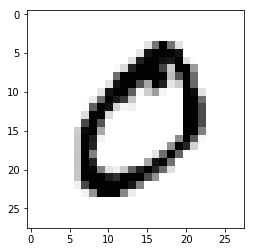

In [4]:
all_values = data_list[1].split(',')
image_array = numpy.asfarray(all_values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

In [102]:
import numpy as np

class Layer:
    """
    Base class for layers in the network.

    Arguments:

        `inbound_layers`: A list of layers with edges into this layer.
    """
    def __init__(self, inbound_layers=[]):
        """
        Layer's constructor (runs when the object is instantiated). Sets
        properties that all layers need.
        """
        # A list of layers with edges into this layer.
        self.inbound_layers = inbound_layers
        # The eventual value of this layer. Set by running
        # the forward() method.
        self.value = None
        # A list of layers that this layer outputs to.
        self.outbound_layers = []
        # New property! Keys are the inputs to this layer and
        # their values are the partials of this layer with
        # respect to that input.
        self.gradients = {}
        # Sets this layer as an outbound layer for all of
        # this layer's inputs.
        for layer in inbound_layers:
            layer.outbound_layers.append(self)

    def forward():
        """
        Every layer that uses this class as a base class will
        need to define its own `forward` method.
        """
        raise NotImplementedError

    def backward():
        """
        Every layer that uses this class as a base class will
        need to define its own `backward` method.
        """
        raise NotImplementedError


class Input(Layer):
    """
    A generic input into the network.
    """
    def __init__(self):
        # The base class constructor has to run to set all
        # the properties here.
        #
        # The most important property on an Input is value.
        # self.value is set during `topological_sort` later.
        Layer.__init__(self)

    def forward(self):
        # Do nothing because nothing is calculated.
        pass

    def backward(self):
        # An Input layer has no inputs so the gradient (derivative)
        # is zero.
        # The key, `self`, is reference to this object.
        self.gradients = {self: 0}
        # Weights and bias may be inputs, so you need to sum
        # the gradient from output gradients.
        for n in self.outbound_layers:
            self.gradients[self] += n.gradients[self]

class Linear(Layer):
    """
    Represents a layer that performs a linear transform.
    """
    def __init__(self, X, W, b):
        # The base class (Layer) constructor. Weights and bias
        # are treated like inbound layers.
        Layer.__init__(self, [X, W, b])

    def forward(self):
        """
        Performs the math behind a linear transform.
        """
        X = self.inbound_layers[0].value
        W = self.inbound_layers[1].value
        b = self.inbound_layers[2].value
        self.value = np.dot(X, W) + b

    def backward(self):
        """
        Calculates the gradient based on the output values.
        """
        # Initialize a partial for each of the inbound_layers.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_layers}
        # Cycle through the outputs. The gradient will change depending
        # on each output, so the gradients are summed over all outputs.
        for n in self.outbound_layers:
            # Get the partial of the cost with respect to this layer.
            grad_cost = n.gradients[self]
            # Set the partial of the loss with respect to this layer's inputs.
            self.gradients[self.inbound_layers[0]] += np.dot(grad_cost, self.inbound_layers[1].value.T)
            # Set the partial of the loss with respect to this layer's weights.
            self.gradients[self.inbound_layers[1]] += np.dot(self.inbound_layers[0].value.T, grad_cost)
            # Set the partial of the loss with respect to this layer's bias.
            self.gradients[self.inbound_layers[2]] += np.sum(grad_cost, axis=0, keepdims=False)


class Sigmoid(Layer):
    """
    Represents a layer that performs the sigmoid activation function.
    """
    def __init__(self, layer):
        # The base class constructor.
        Layer.__init__(self, [layer])

    def _sigmoid(self, x):
        """
        This method is separate from `forward` because it
        will be used with `backward` as well.

        `x`: A numpy array-like object.
        """
        return 1. / (1. + np.exp(-x))

    def forward(self):
        """
        Perform the sigmoid function and set the value.
        """
        input_value = self.inbound_layers[0].value
        self.value = self._sigmoid(input_value)

    def backward(self):
        """
        Calculates the gradient using the derivative of
        the sigmoid function.
        """
        # Initialize the gradients to 0.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_layers}
        # Sum the partial with respect to the input over all the outputs.
        for n in self.outbound_layers:
            grad_cost = n.gradients[self]
            sigmoid = self.value
            self.gradients[self.inbound_layers[0]] += sigmoid * (1 - sigmoid) * grad_cost


class MSE(Layer):
    def __init__(self, y, a):
        """
        The mean squared error cost function.
        Should be used as the last layer for a network.
        """
        # Call the base class' constructor.
        Layer.__init__(self, [y, a])

    def forward(self):
        """
        Calculates the mean squared error.
        """
        # NOTE: We reshape these to avoid possible matrix/vector broadcast
        # errors.
        #
        # For example, if we subtract an array of shape (3,) from an array of shape
        # (3,1) we get an array of shape(3,3) as the result when we want
        # an array of shape (3,1) instead.
        #
        # Making both arrays (3,1) insures the result is (3,1) and does
        # an elementwise subtraction as expected.
        y = self.inbound_layers[0].value#.reshape(-1, 1)
        a = self.inbound_layers[1].value#.reshape(-1, 1)

        self.m = self.inbound_layers[0].value.shape[0]
        # Save the computed output for backward.
        self.diff = y - a
        self.value = np.mean(self.diff**2)

    def backward(self):
        """
        Calculates the gradient of the cost.
        """
        self.gradients[self.inbound_layers[0]] = (2 / self.m) * self.diff
        self.gradients[self.inbound_layers[1]] = (-2 / self.m) * self.diff


def topological_sort(feed_dict):
    """
    Sort the layers in topological order using Kahn's Algorithm.

    `feed_dict`: A dictionary where the key is a `Input` Layer and the value is the respective value feed to that Layer.

    Returns a list of sorted layers.
    """

    input_layers = [n for n in feed_dict.keys()]

    G = {}
    layers = [n for n in input_layers]
    while len(layers) > 0:
        n = layers.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outbound_layers:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            layers.append(m)

    L = []
    S = set(input_layers)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]

        L.append(n)
        for m in n.outbound_layers:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def forward_and_backward(graph):
    """
    Performs a forward pass and a backward pass through a list of sorted Layers.

    Arguments:

        `graph`: The result of calling `topological_sort`.
    """
    # Forward pass
    for n in graph:
        n.forward()

    # Backward pass
    for n in graph[::-1]:
        n.backward()

def forward(graph):
    # Forward pass
    for n in graph:
        n.forward()

def sgd_update(trainables, learning_rate=1e-2):
    """
    Updates the value of each trainable with SGD.

    Arguments:

        `trainables`: A list of `Input` Layers representing weights/biases.
        `learning_rate`: The learning rate.
    """
    
    # Update all the `trainables` with SGD
    for t in trainables:
	    t.value -= learning_rate * t.gradients[t]
    


In [81]:

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

# Load data
training_data_file = open("mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()
X_ = np.zeros((60000,784))
y_ = np.zeros((60000,1))
i=0
for record in training_data_list:  
    all_values = record.split(',')
    
    # scale and shift the inputs
    X_[i] = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    
    y_[i] = all_values[0]
    i+=1
#print(X_[0])
#print(y_)



In [137]:
n_features = X_.shape[1]
n_hidden = 20
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 500
# Total number of examples
m = X_.shape[0]
batch_size = 10
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

Total number of examples = 10000


In [138]:


# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        forward_and_backward(graph)

        # Step 3
        sgd_update(trainables, 1e-1)

        loss += graph[-1].value

    print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))

W1_ = W1.value
W2_ = W2.value
b1_ = b1.value
b2_ = b2.value

Epoch: 1, Loss: 3.960
Epoch: 2, Loss: 2.469
Epoch: 3, Loss: 2.016
Epoch: 4, Loss: 1.820
Epoch: 5, Loss: 1.652
Epoch: 6, Loss: 1.498
Epoch: 7, Loss: 1.443
Epoch: 8, Loss: 1.390
Epoch: 9, Loss: 1.358
Epoch: 10, Loss: 1.232
Epoch: 11, Loss: 1.209
Epoch: 12, Loss: 1.189
Epoch: 13, Loss: 1.117
Epoch: 14, Loss: 1.124
Epoch: 15, Loss: 1.005
Epoch: 16, Loss: 1.037
Epoch: 17, Loss: 0.978
Epoch: 18, Loss: 0.975
Epoch: 19, Loss: 0.961
Epoch: 20, Loss: 0.917
Epoch: 21, Loss: 0.954
Epoch: 22, Loss: 0.878
Epoch: 23, Loss: 0.917
Epoch: 24, Loss: 0.870
Epoch: 25, Loss: 0.865
Epoch: 26, Loss: 0.866
Epoch: 27, Loss: 0.842
Epoch: 28, Loss: 0.821
Epoch: 29, Loss: 0.752
Epoch: 30, Loss: 0.776
Epoch: 31, Loss: 0.720
Epoch: 32, Loss: 0.752
Epoch: 33, Loss: 0.743
Epoch: 34, Loss: 0.713
Epoch: 35, Loss: 0.693
Epoch: 36, Loss: 0.688
Epoch: 37, Loss: 0.686
Epoch: 38, Loss: 0.644
Epoch: 39, Loss: 0.710
Epoch: 40, Loss: 0.681
Epoch: 41, Loss: 0.657
Epoch: 42, Loss: 0.701
Epoch: 43, Loss: 0.651
Epoch: 44, Loss: 0.6

Epoch: 347, Loss: 0.267
Epoch: 348, Loss: 0.270
Epoch: 349, Loss: 0.269
Epoch: 350, Loss: 0.281
Epoch: 351, Loss: 0.287
Epoch: 352, Loss: 0.261
Epoch: 353, Loss: 0.271
Epoch: 354, Loss: 0.253
Epoch: 355, Loss: 0.257
Epoch: 356, Loss: 0.281
Epoch: 357, Loss: 0.282
Epoch: 358, Loss: 0.251
Epoch: 359, Loss: 0.264
Epoch: 360, Loss: 0.275
Epoch: 361, Loss: 0.245
Epoch: 362, Loss: 0.270
Epoch: 363, Loss: 0.258
Epoch: 364, Loss: 0.264
Epoch: 365, Loss: 0.266
Epoch: 366, Loss: 0.250
Epoch: 367, Loss: 0.250
Epoch: 368, Loss: 0.257
Epoch: 369, Loss: 0.265
Epoch: 370, Loss: 0.252
Epoch: 371, Loss: 0.234
Epoch: 372, Loss: 0.244
Epoch: 373, Loss: 0.266
Epoch: 374, Loss: 0.274
Epoch: 375, Loss: 0.245
Epoch: 376, Loss: 0.245
Epoch: 377, Loss: 0.258
Epoch: 378, Loss: 0.254
Epoch: 379, Loss: 0.257
Epoch: 380, Loss: 0.265
Epoch: 381, Loss: 0.261
Epoch: 382, Loss: 0.263
Epoch: 383, Loss: 0.255
Epoch: 384, Loss: 0.250
Epoch: 385, Loss: 0.252
Epoch: 386, Loss: 0.258
Epoch: 387, Loss: 0.257
Epoch: 388, Loss

In [140]:
test_data_file = open("mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()
X_ = np.zeros((10000,784))
y_ = np.zeros((10000,1))
i=0
for record in test_data_list:  
    all_values = record.split(',')
    
    # scale and shift the inputs
    X_[i] = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    
    y_[i] = all_values[0]
    i+=1

In [141]:
feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}


# Total number of examples
m = X_.shape[0]
batch_size = 10
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)

print("Total number of examples = {}".format(m))

Total number of examples = 10000


In [144]:
cnt = 0
for j in range(10000):
    
    X_batch, y_batch = X_[j], y_[j]

    # Reset value of X and y Inputs
    X.value = X_batch
    y.value = y_batch

    # Step 2
    forward(graph)

    if graph[-1].value < 0.1:
       cnt += 1 

print("count: {}".format(cnt))

count: 6816
